In [1]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'
color_label_train = '../data/mapillary-vistas-dataset_public_v1.1/training/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'
image_train = '../data/mapillary-vistas-dataset_public_v1.1/training/images/'



IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13
#_drivable_id.png
#_drivable_color.png

In [3]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [4]:
from tensorflow.python.client import device_lib

tf.test.gpu_device_name()


'/device:GPU:0'

In [5]:
#Create dictonary for id to new id, add color for each id later. 

color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

In [6]:
classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

In [7]:
def img_array_to_single_val(arr, color_codes):
    result = np.ndarray(shape=arr.shape[:2], dtype=int)
    result[:,:] = -1
    for idx, rgb in color_codes.items():
        result[(arr==rgb).all(2)] = idx
    return result

def id_map(img_label, color_id_map):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]
    
    channel = np.zeros((height, width), dtype=np.int8)
    
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)
        channel += value[0] * mask
    
    
    return channel
    


def random_augment(img, mask_rgb):
    #mask = id_map(img, classes_cc)
    mask = id_map(mask_rgb, color_id_map)


    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        #iaa.Multiply((0.95, 1.05)),
        #iaa.Dropout([0.0, 0.2]),
        #iaa.Add((-20, 20)),
        #iaa.Superpixels(p_replace=0.1, n_segments=16),
        #iaa.Affine(scale=(1, 1.2),translate_percent=(-0.1, 0.1),rotate=(-10, 10),shear=(-2, 2))
        
    ])

    
    height, width, _ = img.shape
    segmap = SegmentationMapsOnImage(mask, shape=img.shape, nb_classes=NUM_SEG)
    
    img_aug, mask = seq(image=img, segmentation_maps=segmap)
    #mask = mask.draw(size=) #classes_cc
    colors = classes_cc.values()
    
    
    mask = mask.draw([height, width, NUM_SEG], colors=colors)[0] #, colors=[(0, 0, 0), (255, 0, 0), (0, 0, 255)]
    #c1, _, _ = cv2.split(mask[0])
    #c2, _, _ = cv2.split(mask[2])
    
    #rb_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 2), dtype=np.uint8)
    #rb_mask[..., 0] = c1
    #rb_mask[..., 1] = c2
    
    return img_aug, mask

def apply_color_map(image_array, labels):
    color_array = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype=np.uint8)
    print(image_array.shape)
    print(color_array.shape)
    for label_id, label in enumerate(labels):
        # set all pixels with the current label to the color of the current label
        #print(label["color"])
        image_array[:,:,:] == label["color"]
        color_array[image_array == label_id] = label["color"]
        #print(color_array[image_array == label_id])

    return color_array

def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)
    a.set_title(title2)

In [8]:
    # read in config file
    with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
        config = json.load(config_file)
    # in this example we are only interested in the labels
    labels = config['labels']

    # print labels
    print("There are {} labels in the config file".format(len(labels)))
    for label_id, label in enumerate(labels):
        color_id_map[label_id].append(label["color"])
        print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

There are 66 labels in the config file
                          Bird ( 0): animal--bird                             has instances: True
                 Ground Animal ( 1): animal--ground-animal                    has instances: True
                          Curb ( 2): construction--barrier--curb              has instances: False
                         Fence ( 3): construction--barrier--fence             has instances: False
                    Guard Rail ( 4): construction--barrier--guard-rail        has instances: False
                       Barrier ( 5): construction--barrier--other-barrier     has instances: False
                          Wall ( 6): construction--barrier--wall              has instances: False
                     Bike Lane ( 7): construction--flat--bike-lane            has instances: False
             Crosswalk - Plain ( 8): construction--flat--crosswalk-plain      has instances: True
                      Curb Cut ( 9): construction--flat--curb-cut        

In [9]:
for key, value in color_id_map.items():
        print(value)

[3, [165, 42, 42]]
[3, [0, 192, 0]]
[8, [196, 196, 196]]
[2, [190, 153, 153]]
[2, [180, 165, 180]]
[3, [90, 120, 150]]
[11, [102, 102, 156]]
[8, [128, 64, 255]]
[7, [140, 140, 200]]
[8, [170, 170, 170]]
[7, [250, 170, 160]]
[8, [96, 96, 96]]
[0, [230, 150, 140]]
[7, [128, 64, 128]]
[7, [110, 110, 110]]
[8, [244, 35, 232]]
[0, [150, 100, 100]]
[1, [70, 70, 70]]
[0, [150, 120, 90]]
[4, [220, 20, 60]]
[4, [255, 0, 0]]
[10, [255, 0, 100]]
[10, [255, 0, 200]]
[6, [200, 128, 128]]
[6, [255, 255, 255]]
[0, [64, 170, 64]]
[0, [230, 160, 50]]
[0, [70, 130, 180]]
[0, [190, 255, 255]]
[0, [152, 251, 152]]
[9, [107, 142, 35]]
[0, [0, 170, 30]]
[3, [255, 255, 128]]
[3, [250, 0, 30]]
[3, [100, 140, 180]]
[3, [220, 220, 220]]
[3, [220, 128, 128]]
[3, [222, 40, 40]]
[3, [100, 170, 30]]
[3, [40, 40, 40]]
[3, [33, 33, 33]]
[7, [100, 128, 160]]
[3, [142, 0, 0]]
[7, [70, 100, 150]]
[5, [210, 170, 100]]
[5, [153, 153, 153]]
[12, [128, 128, 128]]
[5, [0, 0, 80]]
[12, [250, 170, 30]]
[12, [192, 192, 192]]
[1

In [10]:
color_label_val_list = get_img_name(color_label_val)
color_label_train_list = get_img_name(color_label_train)

img_val_list = get_img_name(image_val)
img_train_list = get_img_name(image_train)



print(f'Color label val size: {len(color_label_val_list)}')
print(f'Color  label train size: {len(color_label_train_list)}')
print()
print(f'Img val size size: {len(img_val_list)}')
print(f'Img train size size: {len(img_train_list)}')
print()
print(f'eksmaple path color label: {color_label_train_list[0]}')
print(f'eksmaple path img label: {img_train_list[0]}')

Color label val size: 2000
Color  label train size: 18000

Img val size size: 2000
Img train size size: 18000

eksmaple path color label: ../data/mapillary-vistas-dataset_public_v1.1/training/labels/--NSVcUgfVhFd6uzkqHOOg.png
eksmaple path img label: ../data/mapillary-vistas-dataset_public_v1.1/training/images/--NSVcUgfVhFd6uzkqHOOg.jpg


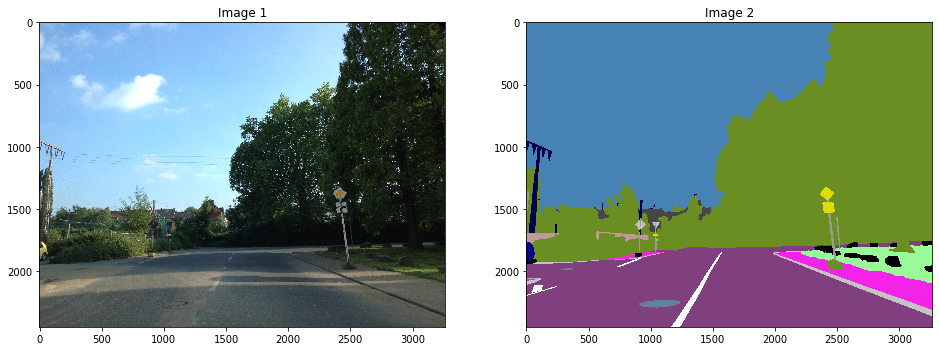

In [11]:
img = cv2.cvtColor(cv2.imread(img_train_list[0]), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(color_label_train_list[0]), cv2.COLOR_BGR2RGB)

compare_img(img, mask)

/home/torresrl/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


(2448, 3264, 3)


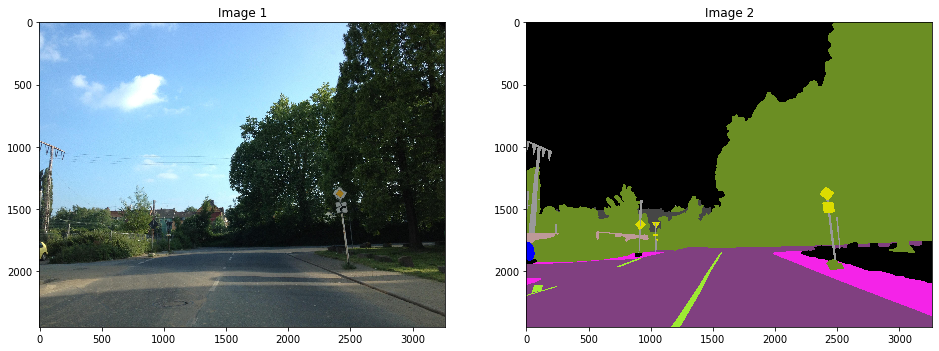

In [12]:
#tror probleme saa langt er at jeg returnere rgb, skal kun ha 1 array med farger. hmmmm

img, mask = random_augment(img, mask)
compare_img(img, mask)
print(mask.shape)

In [13]:
'''
from PIL import Image

# convert labeled data to numpy arrays for better handling
base_image = Image.open(img_val_list[0])
label_image= Image.open(color_label_val_list[0])
instance_image = Image.open('mapillary-vistas-dataset_public_v1.1/training/instances/_0A_W6lEi-7W0RvVEiKkyQ.png')
panoptic_image = Image.open('mapillary-vistas-dataset_public_v1.1/training/panoptic/_0R1piHytmNxzCyp5YjF8g.png')

label_array = np.array(label_image)
instance_array = np.array(instance_image, dtype=np.uint16)

# now we split the instance_array into labels and instance ids
instance_label_array = np.array(instance_array / 256, dtype=np.uint8)
instance_ids_array = np.array(instance_array % 256, dtype=np.uint8)


# for visualization, we apply the colors stored in the config
colored_label_array = apply_color_map(label_array, labels)
colored_instance_label_array = apply_color_map(instance_label_array, labels)


# plot the result
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

ax[0][0].imshow(base_image)
ax[0][0].get_xaxis().set_visible(False)
ax[0][0].get_yaxis().set_visible(False)
ax[0][0].set_title("Base image")
ax[0][1].imshow(colored_label_array)
ax[0][1].get_xaxis().set_visible(False)
ax[0][1].get_yaxis().set_visible(False)
ax[0][1].set_title("Labels")
ax[1][0].imshow(instance_ids_array)
ax[1][0].get_xaxis().set_visible(False)
ax[1][0].get_yaxis().set_visible(False)
ax[1][0].set_title("Instance IDs")
ax[1][1].imshow(colored_instance_label_array)
ax[1][1].get_xaxis().set_visible(False)
ax[1][1].get_yaxis().set_visible(False)
ax[1][1].set_title("Labels from instance file (identical to labels above)")
ax[2][0].imshow(panoptic_image)
ax[2][0].get_xaxis().set_visible(False)
ax[2][0].get_yaxis().set_visible(False)
ax[2][0].set_title("Labels from panoptic")
ax[2][1].axis('off')

fig.tight_layout()
#fig.plot()
#fig.savefig('MVD_plot.png')
'''

'\nfrom PIL import Image\n\n# convert labeled data to numpy arrays for better handling\nbase_image = Image.open(img_val_list[0])\nlabel_image= Image.open(color_label_val_list[0])\ninstance_image = Image.open(\'mapillary-vistas-dataset_public_v1.1/training/instances/_0A_W6lEi-7W0RvVEiKkyQ.png\')\npanoptic_image = Image.open(\'mapillary-vistas-dataset_public_v1.1/training/panoptic/_0R1piHytmNxzCyp5YjF8g.png\')\n\nlabel_array = np.array(label_image)\ninstance_array = np.array(instance_image, dtype=np.uint16)\n\n# now we split the instance_array into labels and instance ids\ninstance_label_array = np.array(instance_array / 256, dtype=np.uint8)\ninstance_ids_array = np.array(instance_array % 256, dtype=np.uint8)\n\n\n# for visualization, we apply the colors stored in the config\ncolored_label_array = apply_color_map(label_array, labels)\ncolored_instance_label_array = apply_color_map(instance_label_array, labels)\n\n\n# plot the result\nfig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,1

In [14]:
'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels


'''
Image augmentation returnes object that is recuced to city shape colors, therfor 
we need other function to create mask 
'''
def labels_to_maskes(img_label, color_map, num_channels):
    num_objects = len(color_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_map.items():
        mask = (img_label ==  value).all(-1)

        channels[..., key] = np.logical_or(channels[:,:, key], mask)

    return channels

masks = labels_to_maskes(mask, classes_cc, NUM_SEG)



In [15]:
print(f'mask shape: {masks.shape}')

mask shape: (2448, 3264, 13)


In [16]:
def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 
    
labels = maskes_to_labels(masks)    
        

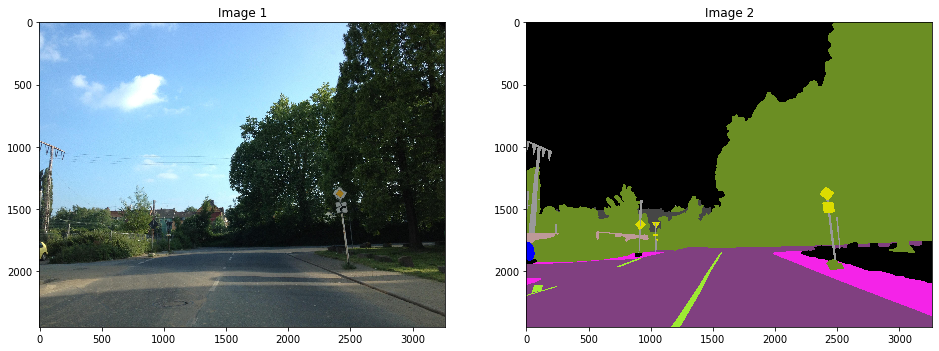

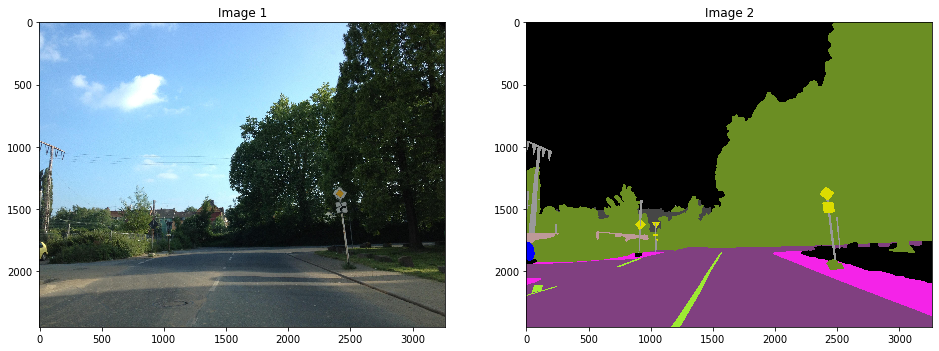

In [17]:
compare_img(img, mask)
compare_img(img, labels)


In [18]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0, training=True):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            index = index_list[i]
            img_url = image_paths_list[index]
            label_url = label_path_list[index]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)
            
            if training:
                img, mask = random_augment(img, mask)
                mask = labels_to_maskes(mask, classes_cc, NUM_SEG)
            else:
                mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [19]:

x_train_gen, y_train_gen = next(batch_generator(img_train_list, color_label_train_list, color_id_map, [5,4], 1))

In [20]:
y_train_maskes = y_train_gen[0]
print(f'mask shape: {y_train_maskes.shape}')

#compare_img(x_train_gen[0]*255, *255)

mask shape: (480, 640, 13)


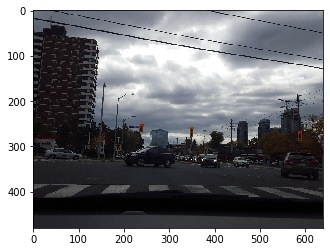

In [21]:
plt.imshow(x_train_gen[0])

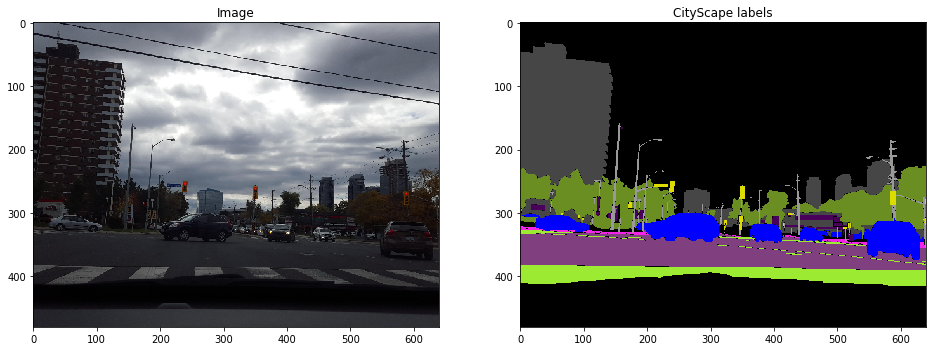

In [22]:
y_train_label = maskes_to_labels(y_train_maskes)
compare_img(x_train_gen[0], y_train_label, 'Image', 'CityScape labels')


In [23]:
def create_setup(dataset, min_data, max_data, arc):
    dropout = random.uniform(0.1, 0.5)
    print(dropout)
    dropout = round(dropout, 2)
    data_amount = random.randint(min_data, max_data) #np.random.randint(low=min_data, high=max_data)
    
    architecture = arc
    created = round(time.time())
    
    optimizers = ['Adam', 'SGD']#[Adam(lr=1e-3), SGD(lr=1e-3)]
    
    activation_func_list = ['relu', 'elu', 'sigmoid', 'tanh', 'hard_sigmoid', 'selu']
    
    activation_func = np.random.choice(activation_func_list, 1, p=[0.5, 0.2, 0.1, 0.1, 0.05, 0.05])[0]
    optimizer = np.random.choice(optimizers, 1, p=[0.6, 0.4])[0]
    
    training_time = 0
    
    model_info = {}
    name = f'{architecture}_{created}.h5'
    
    model_info[name] = {
        'created': created, 
        'training_time': 0,
        'data_amount': data_amount,
        'architecture': arc,
        'dataset': dataset,
        'notes': 'no modification',
        'activation_func': activation_func,
        'dropout': dropout,
        'optimizer': optimizer
    }
            
    
    return model_info, name
    
    

def save_model(model, name, model_info):
    model.save(f'seg_models/{name}.h5')

    json_file_name = 'model_info.json'

    with open(json_file_name, 'r') as file_reader:
        model_data = json.load(file_reader)

    model_data.update(model_info)
    file_reader.close()

    with open(json_file_name, "w") as file_write:
    # write json data into file
        json.dump(model_data, file_write)
    file_write.close() 
    

In [24]:
'''
#standard categorical cross entropy
# N data points, C classes
# true - true values. Shape: (N, C)
# Pred - predicted vlaues. Shape: (N, C)
# returns - loss (N)

def categorical_cross_entropy(true, pred):
    return np.sum(true * np.log(pred), axis=1)

# Bayesian categorical cross entropy.
# N data points, C classes, T monte carlo simulations
# true - true values. shape: (N, C)
# pred_var - predicted logit values and variance. Shape: (N, C + 1)
# return - loss (N, )
def bayesian_categorical_crossentropy(T, num_classes):
    def bayesian_vategorical_crossentropy_internal:(true, pred_var):
            # shape: (N, )
            std = K.sqrt(pred_var[:, num_classes:])
            # shape: (N,)
            variance = pred_var[:, num_classes]
            variance_depressor = K.exp(variance) - K.ones_like(variance)
            # shape: (N, C)
            pred = pred_var[:, 0:num_classes]
            # shape: (N, )
            undistorted_loss = K.categorical_cross_entropy(pred, true, from_logits=True)
            # Shape: (T, )
            iterable = K.variable(np.ones(T))
            dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
            monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy(true, pred, dist, undisorted_loss, num_clases), iterable, name='monte_carlo_results')
            
            variance_loss = K.mean(monte_carlo_results, axis=0) * undisorted_loss
            
            return variance_loss + undistorted_loss + variance_depressor
        return bayesian_vategorical_crossentropy_internal
    

# for a simple monte carlo simulation,
#   calculate categorical_crossentropy of
#   predicted logit values plus gaussian
#   noise vs true vaues 
# true - true values. shape: (N, C)
# pred predicted logit values. shape (N, C)
# undistored_loss - the crosenntropy loss whitput variance distortion. Shape: (N,)
# num_classes - the number of classes. C
# returns - total diffreences for all classes (N, )
def gaussian_categorical_crossentropy(true, pred, dist, undistorted_loss, num_classes):
    def map_fn(i):
        std_samples = K.transpose(dist.sample(num_classes))
        distorted_loss = K.categorical_crossentropy(pred+std_samples, true, from_logits=True)
        diff = undistored_loss - distorted_loss
        return -K.elu(diff)
    return map_fn
'''
            

"\n#standard categorical cross entropy\n# N data points, C classes\n# true - true values. Shape: (N, C)\n# Pred - predicted vlaues. Shape: (N, C)\n# returns - loss (N)\n\ndef categorical_cross_entropy(true, pred):\n    return np.sum(true * np.log(pred), axis=1)\n\n# Bayesian categorical cross entropy.\n# N data points, C classes, T monte carlo simulations\n# true - true values. shape: (N, C)\n# pred_var - predicted logit values and variance. Shape: (N, C + 1)\n# return - loss (N, )\ndef bayesian_categorical_crossentropy(T, num_classes):\n    def bayesian_vategorical_crossentropy_internal:(true, pred_var):\n            # shape: (N, )\n            std = K.sqrt(pred_var[:, num_classes:])\n            # shape: (N,)\n            variance = pred_var[:, num_classes]\n            variance_depressor = K.exp(variance) - K.ones_like(variance)\n            # shape: (N, C)\n            pred = pred_var[:, 0:num_classes]\n            # shape: (N, )\n            undistorted_loss = K.categorical_cross_

In [25]:




def create_model(activation, dropout, mc=True):
    #activation = 'relu'
    #dropout = 0.3 # 0.15
    #mc = True #if droput shoud ocure after training

    img_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))#640x480, 320x240

    conv1 = Conv2D(64, (3, 3), activation=activation, padding='same')(img_input)
    conv1 = Dropout(dropout)(conv1, training=mc)
    conv1 = Conv2D(64, (3, 3), activation=activation, padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation=activation, padding='same')(pool1)
    conv2 = Dropout(dropout)(conv2, training=mc)
    conv2 = Conv2D(128, (3, 3), activation=activation, padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation=activation, padding='same')(pool2)
    conv3 = Dropout(dropout)(conv3, training=mc)
    conv3 = Conv2D(256, (3, 3), activation=activation, padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation=activation, padding='same')(pool3)
    conv4 = Dropout(dropout)(conv4, training=mc)
    conv4 = Conv2D(512, (3, 3), activation=activation, padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation=activation, padding='same')(up1)
    conv5 = Dropout(dropout)(conv5, training=mc)
    conv5 = Conv2D(256, (3, 3), activation=activation, padding='same')(conv5)

    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation=activation, padding='same')(up2)
    conv6 = Dropout(dropout)(conv6, training=mc)
    conv6 = Conv2D(128, (3, 3), activation=activation, padding='same')(conv6)


    up3 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation=activation, padding='same')(up3)
    conv7 = Dropout(dropout)(conv7, training=mc)
    conv7 = Conv2D(32, (3, 3), activation=activation, padding='same')(conv7)

    out = Conv2D(NUM_SEG, (1,1), padding='same', activation='sigmoid')(conv7)

    model = Model(inputs=[img_input], outputs=[out])

    #optimizer = Adam(lr=1e-3) #10 epocher er bra på -3
    return model #.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[MeanIoU(num_classes=NUM_SEG)])#'accuracy'
    

In [26]:
#model.summary()

In [ ]:
ROUNDS = 1
for round_num in range(ROUNDS):
    
    train_data_size = len(color_label_train_list)
    val_data_size = len(color_label_val_list)
    
    model_info, name = create_setup('map_vista', 100, 150, 'u-net')
    activation = model_info[name]['activation_func']
    dropout = model_info[name]['dropout']
    data_amount = model_info[name]['data_amount']
    if model_info[name]['optimizer'] == 'Adam':
        optimizer= Adam(lr=1e-3)
    elif model_info[name]['optimizer'] == 'SGD':
        optimizer = SGD(lr=1e-3)
    
    if True:
        optimizer = Adam(lr=1e-3)
        data_amount = 5000
        dropout = 0.15
        activation = 'relu'
    #indexes_train =  np.random.Generator.integers(0, high=train_data_size, size=data_amount, dtype=np.uint8)
    #indexes_val =  np.random.Generator.integers(0, high=val_data_size, size=data_amount//5, dtype=np.uint8)
    
    indexes_train = random.sample(range(0,train_data_size), data_amount)
    indexes_val = random.sample(range(0,val_data_size), data_amount//5)

    
    model = create_model(activation, dropout)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[MeanIoU(num_classes=NUM_SEG)])#'accuracy'
    #print(f'data amount: {data_amount}')
    if data_amount < 16:
        batch_size=8
    elif data_amount < 32:
        batch_size=16
    else:
        batch_size=32
        
    #amount_data = model_info[name]['amount_data']
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    batch_size =  1#32 
    stp = ((data_amount) // batch_size)
    history = model.fit(batch_generator(img_train_list, color_label_train_list, color_id_map, indexes_train, batch_size), 
                                    steps_per_epoch= stp, #stp
                                    epochs=3, #10 hvirker mer en nokk
                                    validation_data=batch_generator(img_val_list, color_label_val_list, color_id_map, indexes_val, 1, training= False), #100
                                    validation_steps=stp//5, # 200
                                    verbose=1,
                                    callbacks=[es],
                                    use_multiprocessing=True)
    
    save_model(model, name, model_info)
    print()
    print()
    print(f'round: {round_num} in {ROUNDS}')
    print()
    print()

0.3411594959523839
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5000 steps, validate for 1000 steps
Epoch 1/3
 500/5000 [==>...........................] - ETA: 45:41 - loss: 0.1459 - mean_io_u: 0.4738

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('Epoch')

In [ ]:
x_train_val, y_train_val = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [5,4], 1, training= False))


img_predicted = model.predict(x_train_val)[0]
target = maskes_to_labels(y_train_val[0]).astype(np.uint8)

print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
compare_img(x_train_val[0], target, 'Image', 'CityScape labels')
compare_img(x_train_val[0], y_train_label, 'Image', 'CityScape labels')

In [ ]:
print(f'image: {x_train_val[0].dtype}')
print(f'predictions: {y_train_label.dtype}')

In [ ]:


img_mask = cv2.addWeighted(y_train_label, 0.5, x_train_val[0], 0.5, 0)
img_target = cv2.addWeighted(target, 0.5, x_train_val[0], 0.5, 0)

compare_img(img_mask, img_target)

In [ ]:
#model.save(f'../seg_models/u-net_mc_4_30.h5')

In [ ]:
#model = load_model('../seg_models/u-net_mc_4_30.h5')

## Test Monte Carlo, uncertenty


In [ ]:
x_train_val, y_train_val = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [1], 1, training= False))
img_predicted = model.predict(x_train_val)[0]

#model = model that have the prediction
#T number of test rounds
# returns mean prediction and uncertenty 
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std
    
    
# prob - predictions probability for each class(c). Shape(N, C)
# returns - Shape(N)
def predictive_entropy(prob):
    return -1 * np.sum(np.log(prob) * prob, axis=1) 

target = maskes_to_labels(y_train_val[0]).astype(np.uint8)
predicted_target,_ ,prediction_std = predictions_and_uncetrenty(model, 100, x_train_val)
print(prediction_std.shape)
#print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
uncertenty_predction = maskes_to_labels(predicted_target).astype(np.uint8)


compare_img(x_train_val[0], target, 'Image', 'CityScape labels')
compare_img(x_train_val[0], y_train_label, 'Image', 'CityScape labels')
compare_img(uncertenty_predction, y_train_label, 'Monte carlo predictiom', 'normal prediction')
compare_img(uncertenty_predction, prediction_std, 'Monte carlo predictiom', 'variance')

In [ ]:
print(prediction_std.mean()) #

In [ ]:
# rounds: 5 mean var: 0.0035581593
# rounds: 10 sum variance: 1188 
# rounds: 100 sum variance: 1317
# rounds: 500 sum variance: 1331
import scipy.stats
"""
create a general model for base line
"""
def print_normal_dist(model, img, target, N):
     
    target_labels = maskes_to_labels(target[0]).astype(np.uint8)
    print(target_labels.shape)
    print(img.shape)
    
    img_and_target_labels = cv2.addWeighted(target_labels, 0.5, img[0], 0.5, 0)
    
    #do monte carlo predictions
    predicted_target, prediction_mean ,prediction_std = predictions_and_uncetrenty(model, N, img)

    
    # 2d array of mean of certenty 
    predicted_mean = np.mean(prediction_mean)#np.amax(predicted_target, axis=2)
    
    #make classes to rgb image with right color
    predction_labels = maskes_to_labels(predicted_target).astype(np.uint8)
    img_prediction = cv2.addWeighted(predction_labels, 0.5, img[0], 0.5, 0)
    
    compare_img(img_and_target_labels, img_prediction, 'Target', f'Monte Carlo {N} rounds')
    
    #plot normal distribution
    x_min = 0.0
    x_max = 1.0
    
    mean = predicted_mean.mean()
    std = prediction_std.mean()
    
    print(f'mean: {mean}')
    print(f'std: {std}')
    
    fig = plt.figure(figsize=(16, 5))
    a = fig.add_subplot(1,2,1)
    
    x = np.linspace(x_min, x_max, 100)
    y = scipy.stats.norm.pdf(x, mean, std)
    plt.plot(x,y, color='black')
    plt.grid()
    plt.xlim(x_min, x_max)
    plt.ylim(0.5)
    #plt.show()
    
    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(prediction_std)
    a.set_title("standard derivation in image")
    

    imgplot = plt.show()
    a.set_title('Normal distribution of all pixels')
    
predicted_target_2d = np.amax(predicted_target, axis=2)
print(predicted_target_2d.mean())
print_normal_dist(model, x_train_val, y_train_val, 5)

In [ ]:
print_normal_dist(model, x_train_val, y_train_val, 10)

In [ ]:
print_normal_dist(model, x_train_val, y_train_val, 100)

In [ ]:
print_normal_dist(model, x_train_val, y_train_val, 500)